<a href="https://colab.research.google.com/github/mahad-asim76/Data/blob/master/FYP_Mid_Progress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance

In [66]:
import math
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default="colab"
from datetime import date, timedelta
today = date.today()

In [67]:
d1 = date.today() + timedelta(days=1)
d1 = d1.strftime("%Y-%m-%d")
end_date = d1
d2 = date.today() - timedelta(days=1521)
d2 = d2.strftime("%Y-%m-%d")
start_date = d2

In [ ]:
df = yf.download('BTC-USD', start=start_date, end=end_date, progress=False)
df.tail(5)

In [69]:
df.shape

(1522, 6)

In [70]:
trace1 = go.Scatter(
    x = df['Open'].index,
    y = df['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = df['Close'].index,
    y = df['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)
trace3 = go.Scatter(
    x = df['High'].index,
    y = df['High'].astype(float),
    mode = 'lines',
    name = 'High'
)

layout = dict(
    title='Historical Bitcoin Prices with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

Data = [trace1, trace2, trace3]
fig = dict(data=Data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

In [71]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .8) # We are using %80 of the data for training

In [72]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [73]:
train_data = scaled_data[0:training_data_len, :]
X_train = []
y_train = []
for i in range(60, len(train_data)):
  X_train.append(train_data[i-60: i, 0])
  y_train.append(train_data[i, 0])

In [74]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [75]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1158, 60, 1)

In [76]:
test_data = scaled_data[training_data_len - 60 : , :]
X_test = []
y_test = dataset[training_data_len : , :]
for i in range(60, len(test_data)):
  X_test.append(test_data[i-60 : i, 0])

In [77]:
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [78]:
from keras.layers.attention.multi_head_attention import activation
# Build LSTM Model
Model = Sequential()
Model.add(LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='sigmoid'))
Model.add(LSTM(60, return_sequences=False))
Model.add(Dense(1))

In [79]:
# Compile the model
Model.compile(optimizer='adam', loss='mse')
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)
history = Model.fit(X_train, y_train, batch_size=1, epochs=30)

Epoch 1/30
1158/1158 [==============================] - 49s 41ms/step - loss: 0.0303
Epoch 2/30
1158/1158 [==============================] - 32s 28ms/step - loss: 0.0024
Epoch 3/30
1158/1158 [==============================] - 34s 29ms/step - loss: 0.0017
Epoch 4/30
1158/1158 [==============================] - 35s 30ms/step - loss: 0.0014
Epoch 5/30
1158/1158 [==============================] - 32s 28ms/step - loss: 0.0012
Epoch 6/30
1158/1158 [==============================] - 32s 28ms/step - loss: 0.0011
Epoch 7/30
1158/1158 [==============================] - 32s 27ms/step - loss: 9.0399e-04
Epoch 8/30
1158/1158 [==============================] - 32s 27ms/step - loss: 9.7574e-04
Epoch 9/30
1158/1158 [==============================] - 32s 27ms/step - loss: 8.3458e-04
Epoch 10/30
1158/1158 [==============================] - 32s 28ms/step - loss: 8.6414e-04
Epoch 11/30
1158/1158 [==============================] - 32s 28ms/step - loss: 6.7167e-04
Epoch 12/30
1158/1158 [====================

In [80]:
# Get the Model predicted price values 
prediction = Model.predict(X_test)
prediction = scaler.inverse_transform(prediction)

10/10 [==============================] - 1s 21ms/step


<ipython-input-81-d298854db8cd>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



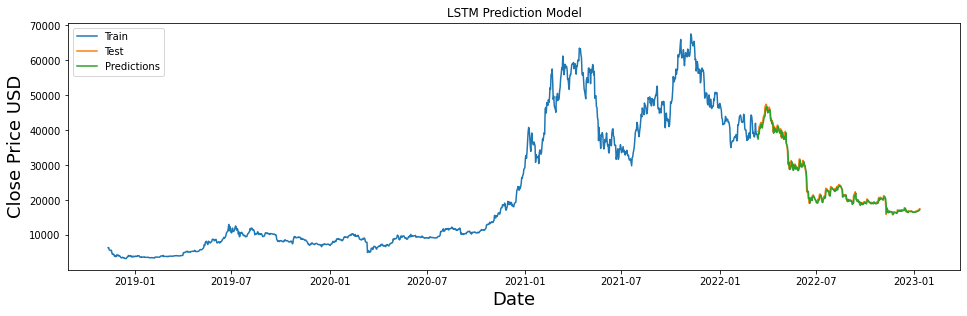

In [81]:
# Plot the data
train = data[:training_data_len]
valid_1 = data[training_data_len:]
valid_1['Predictions'] = prediction
plt.figure(figsize=(16, 10))
plt.subplot(2, 1, 1)
plt.title('LSTM Prediction Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid_1[['Close', 'Predictions']])
plt.legend(['Train', 'Test', 'Predictions'], loc='upper left')
plt.show()

In [82]:
#Get the last 8 day closing price values and convert the datadrame to an array
last_60_days = data[-8:].values
last_60_days_scaled = scaler.fit_transform(last_60_days)
new_X_test = []
new_X_test.append(last_60_days_scaled)
new_X_test = np.array(new_X_test)
new_X_test = np.reshape(new_X_test, (new_X_test.shape[1], new_X_test.shape[0], 1))
pred_price = Model.predict(new_X_test)
pred_price = scaler.inverse_transform(pred_price)
pred_price = np.array(pred_price)

1/1 [==============================] - 1s 724ms/step


In [83]:
df_total = pd.DataFrame(valid_1)
df_total.reset_index(inplace = True)

In [84]:
trace1 = go.Scatter(
    x = df_total['Date'],
    y =  df_total['Close'],
    mode = 'lines',
    name = 'Test'
)

trace2 = go.Scatter(
    x = df_total['Date'],
    y = df_total['Predictions'],
    mode = 'lines',
    name = 'Predicted'
)
Data = [trace1, trace2]
fig = dict(data=Data)
iplot(fig, filename = "Time Series with Rangeslider")

In [85]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
Mae_accuracy = mean_absolute_error(y_test, prediction)
rmse = np.sqrt(mean_squared_error(y_test, prediction))
print('Root Mean Square Error: ', rmse)
print("MAE: ", Mae_accuracy)

Root Mean Square Error:  858.8029169757848
MAE:  580.9679661800986


In [86]:
pred_price = np.flip(pred_price)
df_pred = pd.DataFrame(pred_price, columns = ["Forecast"])
datestamp = []
for i in range(1, len(pred_price)):
  date = date.today() + timedelta(days=i)
  datestamp.append(date)

df_date = pd.DataFrame(datestamp, columns = ["Date"])
df_forecast = pd.concat([df_date, df_pred], axis=1, join='inner')
df_forecast

,Date,Forecast
0,2023-01-12,17544.083984
1,2023-01-13,17496.455078
2,2023-01-14,17302.224609
3,2023-01-15,17200.099609
4,2023-01-16,17053.828125
5,2023-01-17,17050.359375
6,2023-01-18,16921.060547


In [87]:
trace1 = go.Scatter(
    x = df_forecast['Date'],
    y = df_forecast['Forecast'],
    mode = 'lines',
    name = 'Forcast'
)

Data = [trace1]
fig = dict(data=Data)
iplot(fig, filename = "Time Series with Rangeslider")